In [ ]:
! pip install scikit-image imgaug

# Importing Libraries

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from skimage import filters
import imgaug.augmenters as iaa


In [ ]:
from google.colab import files

#上船你的Kaggle 密鑰

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:01<00:00, 177MB/s]
100% 5.20G/5.20G [01:01<00:00, 90.7MB/s]


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

# Import Data

In [ ]:
import pandas as pd
data = pd.read_csv('hmnist_28_28_RGB.csv')
data.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [ ]:
y = data['label']
x = data.drop(columns = ['label'])

# Exploratory Data Analysis (EDA)

In [ ]:
tabular_data = pd.read_csv('HAM10000_metadata.csv')
tabular_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
#在這個階段還沒有正常的組別，我們在modle transfer 的時候才會加進去
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

# Frequency Distribution of Classes

Text(0.5, 1.0, 'Frequency Distribution of Classes')

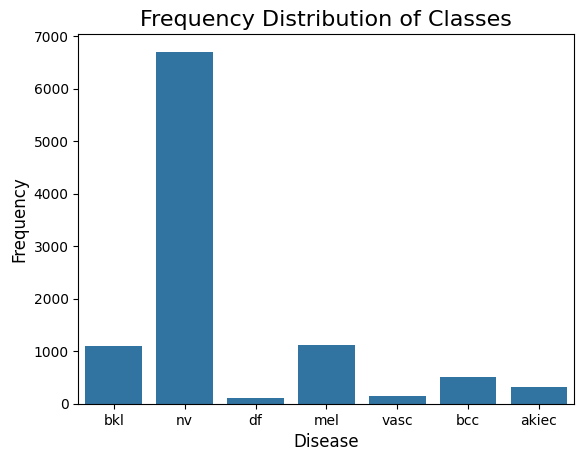

In [ ]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

#我們可以看到資料有嚴重的不平衡，所以之後我們會做oversample

# Distribution of Disease over Gender

Text(0.5, 1.0, 'Gender of Patient')

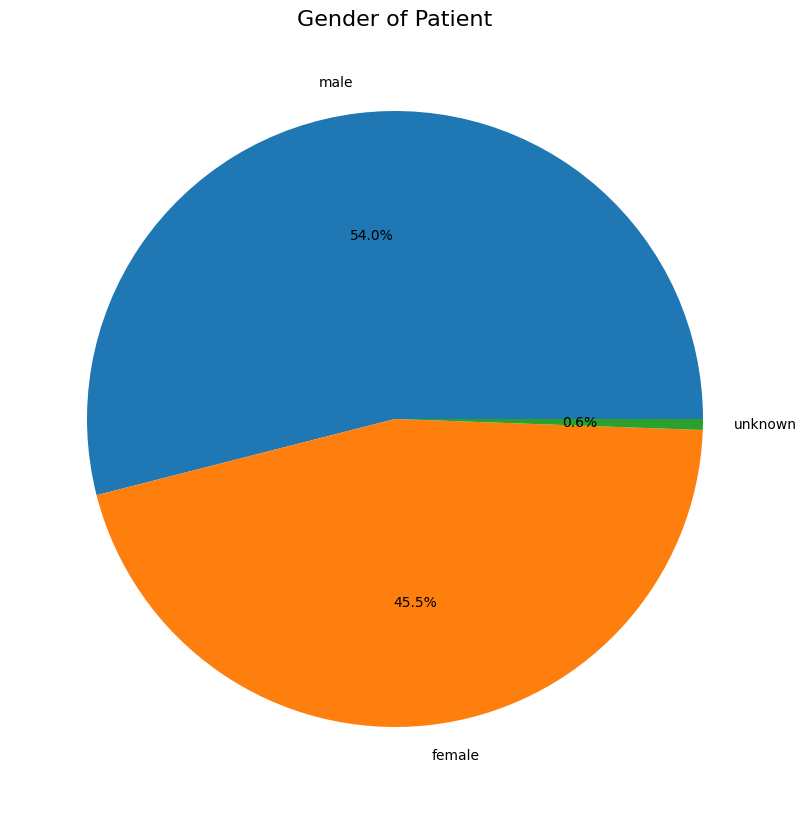

In [ ]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

# Histogram of Age of Patients

Text(0.5, 1.0, 'Histogram of Age of Patients')

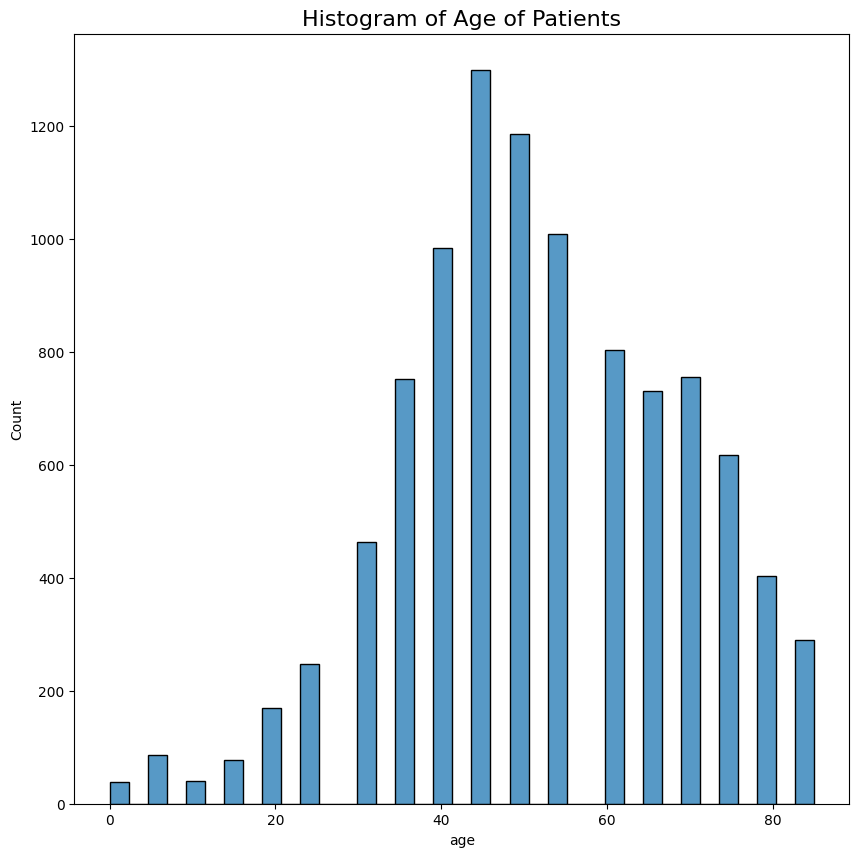

In [ ]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

# Location of disease over Gender

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

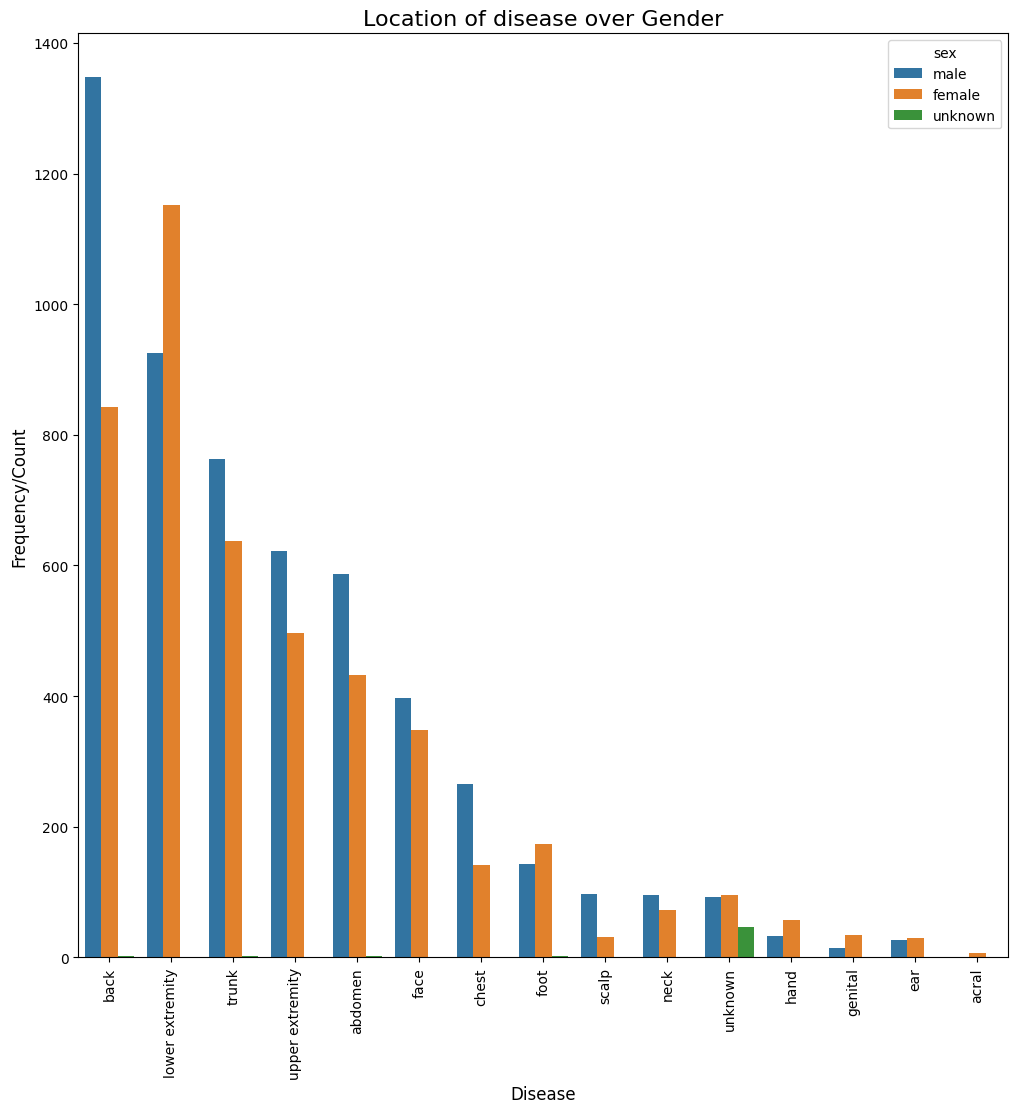

In [ ]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

# Oversampling
**To overcome class imbalace**

In [ ]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (4480, 28, 28, 3)


# Standardization and Splitting Data

In [ ]:
x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [ ]:

# 應用高斯模糊
def apply_gaussian_blur(images):
    blurred_images = []
    for image in images:
        # 隨機選擇標準差以增加多樣性
        sigma = np.random.uniform(0.5, 1.5)
        blurred_image = filters.gaussian(image, sigma=sigma, multichannel=True)
        blurred_images.append(blurred_image)
    return np.array(blurred_images)

# 應用圖像扭曲
def apply_image_distortion(images):
    seq = iaa.Sequential([
        iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, rotate=(-25, 25))
    ])
    distorted_images = seq(images=images)
    return distorted_images

# 對訓練數據進行增強
X_train_blurred = apply_gaussian_blur(X_train)
X_train_distorted = apply_image_distortion(X_train)

# 如果你想結合兩種效果
X_train_enhanced = apply_image_distortion(apply_gaussian_blur(X_train))

print('原始訓練集形狀:', X_train.shape)
print('模糊後訓練集形狀:', X_train_blurred.shape)
print('扭曲後訓練集形狀:', X_train_distorted.shape)
print('增強後訓練集形狀:', X_train_enhanced.shape)

<ipython-input-13-270a6898d3d3>:7: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  blurred_image = filters.gaussian(image, sigma=sigma, multichannel=True)


原始訓練集形狀: (37548, 28, 28, 3)
模糊後訓練集形狀: (37548, 28, 28, 3)
扭曲後訓練集形狀: (37548, 28, 28, 3)
增強後訓練集形狀: (37548, 28, 28, 3)


# Model Training

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                   

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)


In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback])

# Plot Accuracy and Loss

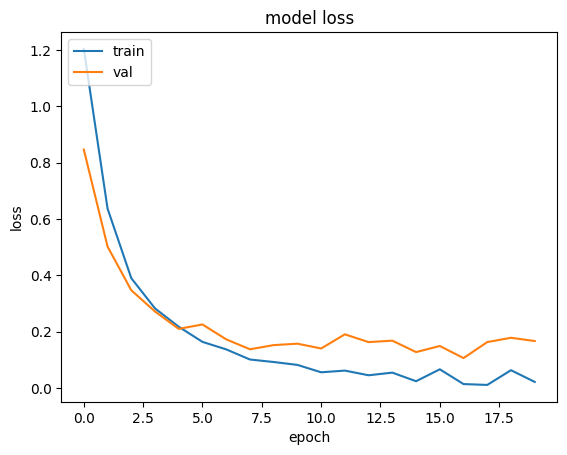

In [ ]:
import matplotlib.pyplot as plt

# 繪製損失圖表
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# 繪製準確率圖表
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


# Model Testing

In [ ]:
model.load_weights('best_model.h5')

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 8s - loss: 0.1768 - accuracy: 0.9679 - 8s/epoch - 26ms/step


# Model Inference

In [ ]:
!pip install google.colab
from google.colab.patches import cv2_imshow
srcdir = 'HAM10000_images_part_1'
count=0
for temp in os.listdir(srcdir):
    img = cv2.imread(os.path.join(srcdir, temp))
    cv2.imwrite(temp, img)
    cv2_imshow(img)
    img = cv2.resize(img, (28, 28))
    result = model.predict(img.reshape(1, 28, 28, 3))
    print(result)
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    count+=1
    if count>10:
        break

# Model tranfer

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D
from keras.models import load_model
from keras.models import Model


pretrained_model = load_model('best_model.h5')

x = pretrained_model.layers[-2].output

#最後一項改成輸出八種類別
predictions = Dense(8, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

#把一到七層的參數鎖死，只訓練後面的
for layer in pretrained_model.layers[1:7]:
    layer.trainable = False


model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                           

In [ ]:
classes = {7: ('nm','normal'), 4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

data = pd.read_csv('model_data_normal.csv')

print(data.head())

Y = to_categorical(data['label'])
X = data.drop(columns = ['label'])

print(data['label'].min())
print(data['label'].max())


oversample = RandomOverSampler()
X,Y  = oversample.fit_resample(X,Y)
X = (X-np.mean(X))/np.std(X)



X = np.array(X).reshape(-1,28,28,3)
print('Shape of X :',X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


   pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        180        138        116        177        135        113   
1        232        155        125        222        147        116   
2        232        195        177        220        183        165   
3        247        159        109        247        161        110   
4        189        154        116        188        153        115   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        182        137        114        183  ...        198        155   
1        222        149        117        217  ...        209        112   
2        209        170        155        205  ...        181        123   
3        251        165        118        253  ...        193        109   
4        189        154        116        192  ...        163        128   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        136        197        154        135

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Shape of X : (5120, 28, 28, 3)


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np


# 定義回調函數
checkpoint = ModelCheckpoint(
    'best_model_improved.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_delta=0.0001
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

history = model.fit(X_train, Y_train,
                    epochs=25,
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=[ModelCheckpoint('model_extended.h5', save_best_only=True)])



Epoch 1/25
96/96 [==============================] - 6s 54ms/step - loss: 3.1329 - accuracy: 0.2689 - val_loss: 1.6694 - val_accuracy: 0.4053
Epoch 2/25
 2/96 [..............................] - ETA: 6s - loss: 1.5252 - accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 9s 95ms/step - loss: 1.3633 - accuracy: 0.5107 - val_loss: 1.1770 - val_accuracy: 0.5977
Epoch 3/25
96/96 [==============================] - 5s 54ms/step - loss: 0.9140 - accuracy: 0.6696 - val_loss: 0.8267 - val_accuracy: 0.7051
Epoch 4/25
96/96 [==============================] - 4s 42ms/step - loss: 0.5975 - accuracy: 0.7979 - val_loss: 0.5937 - val_accuracy: 0.7930
Epoch 5/25
96/96 [==============================] - 6s 59ms/step - loss: 0.3819 - accuracy: 0.8825 - val_loss: 0.4536 - val_accuracy: 0.8682
Epoch 6/25
96/96 [==============================] - 9s 95ms/step - loss: 0.2404 - accuracy: 0.9271 - val_loss: 0.3886 - val_accuracy: 0.8838
Epoch 7/25
96/96 [==============================] - 5s 49ms/step - loss: 0.1470 - accuracy: 0.9642 - val_loss: 0.3007 - val_accuracy: 0.9160
Epoch 8/25
96/96 [==============================] - 9s 96ms/step - loss: 0.0959 - accuracy: 0.9821 - val_loss: 0.2541 - val_accuracy: 0.9443
Epoch 9/25
96/96 [======

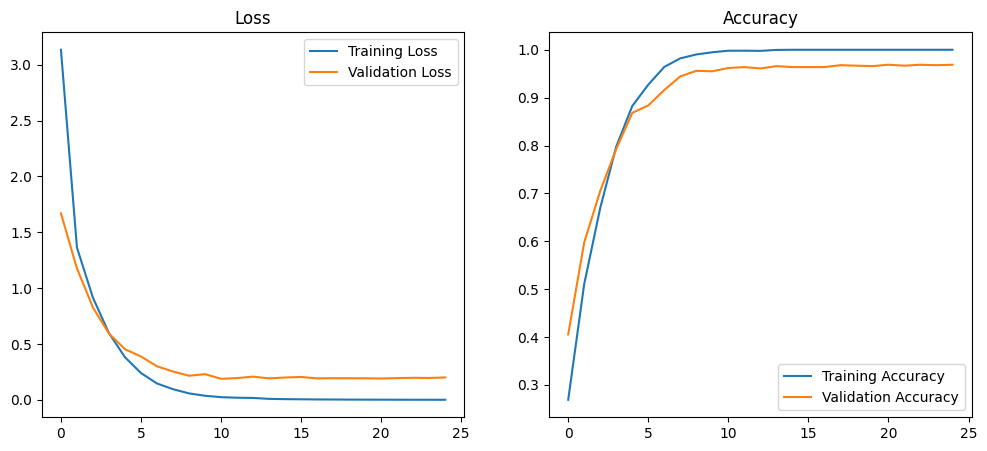

In [ ]:
import matplotlib.pyplot as plt

# 繪製損失圖表
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# 繪製準確率圖表
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


##繪製混淆矩陣


32/32 [==============================] - 1s 14ms/step
模型准确率: 0.96


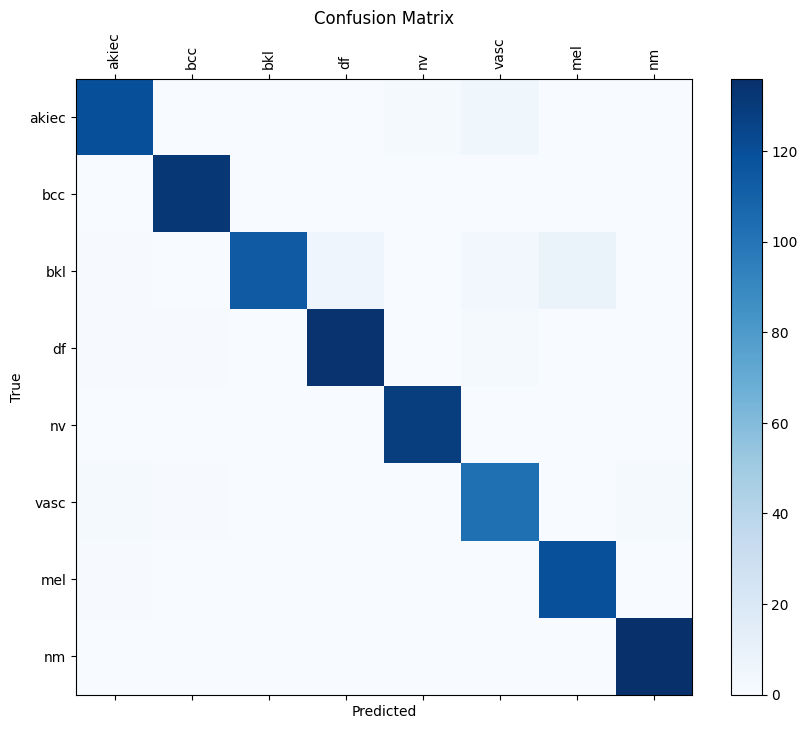

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = Y_test


true_classes = np.argmax(Y_test, axis=1)


accuracy = accuracy_score(true_classes, predicted_classes)
print(f"模型准确率: {accuracy:.2f}")


sorted_classes = sorted(classes.items(), key=lambda item: item[0])
class_names = [f"{abbr}" for _, (abbr, desc) in sorted_classes]


cm = confusion_matrix(true_classes, predicted_classes)


fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)


ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Test set

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

32/32 - 1s - loss: 0.1941 - accuracy: 0.9639 - 918ms/epoch - 29ms/step


## 測試

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


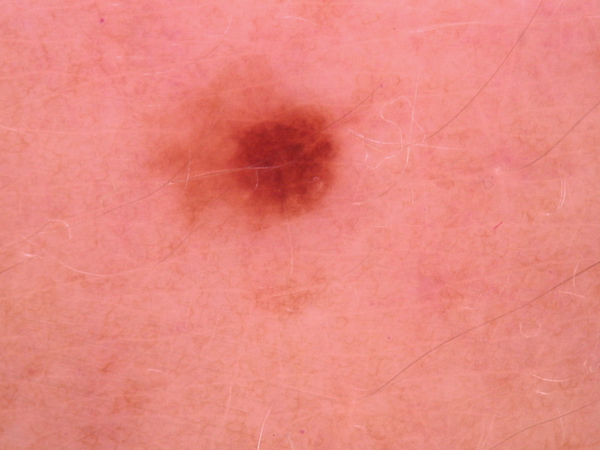

1/1 [==============================] - 0s 147ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


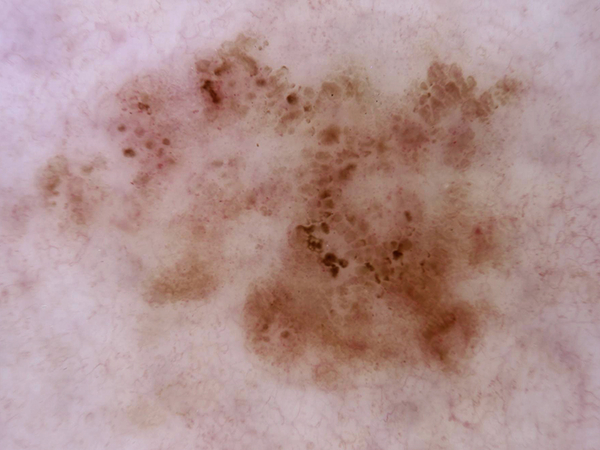

1/1 [==============================] - 0s 33ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


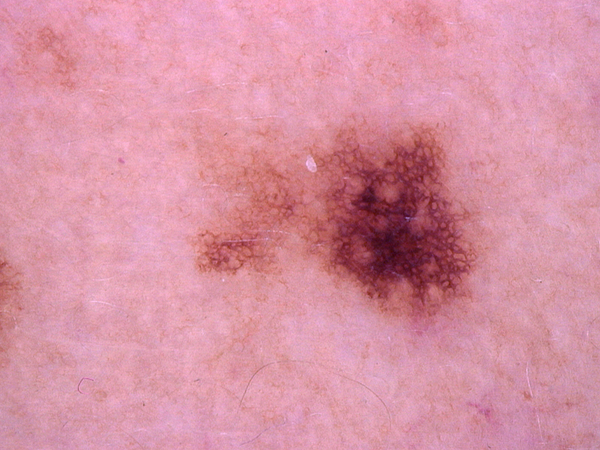

1/1 [==============================] - 0s 30ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


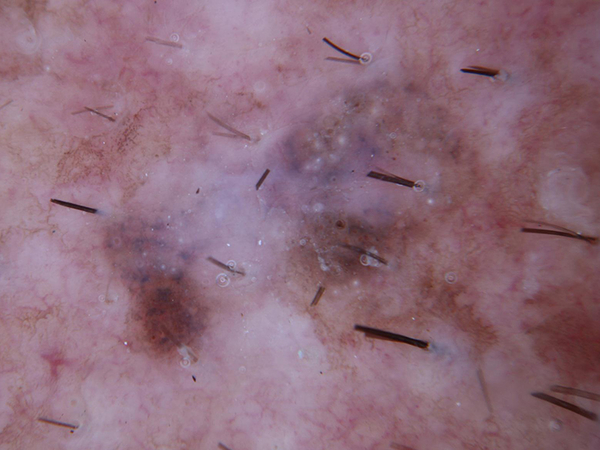

1/1 [==============================] - 0s 31ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


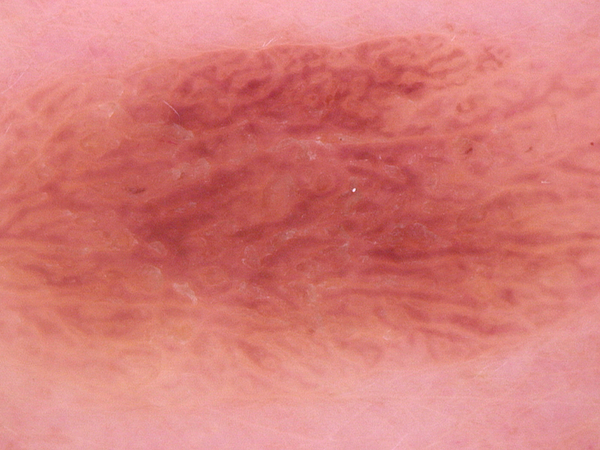

1/1 [==============================] - 0s 46ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


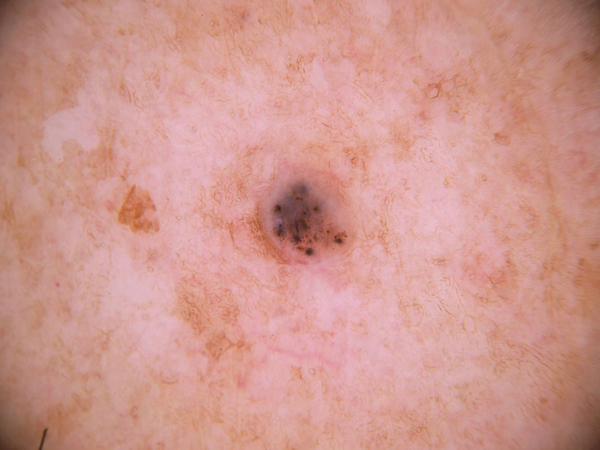

1/1 [==============================] - 0s 36ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


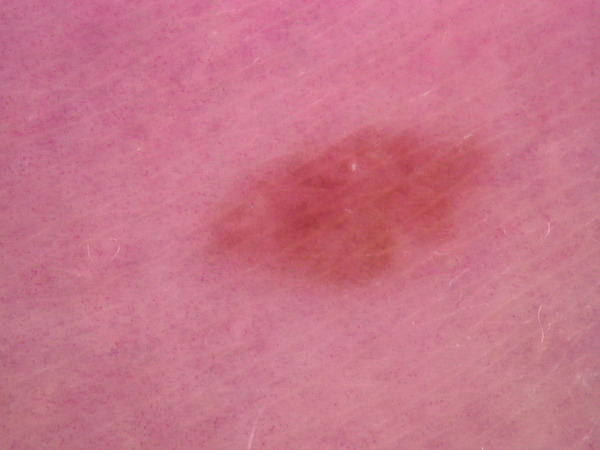

1/1 [==============================] - 0s 37ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


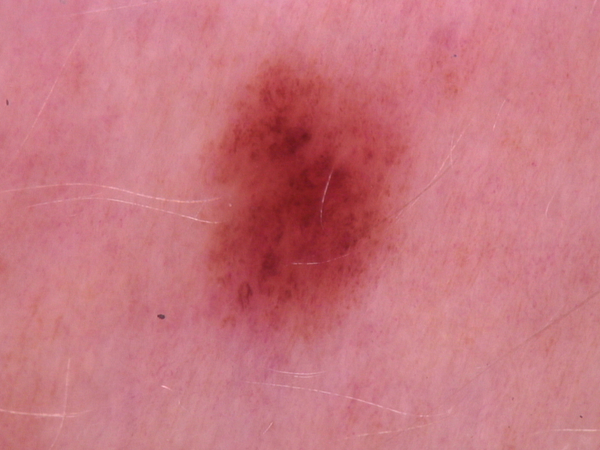

1/1 [==============================] - 0s 32ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


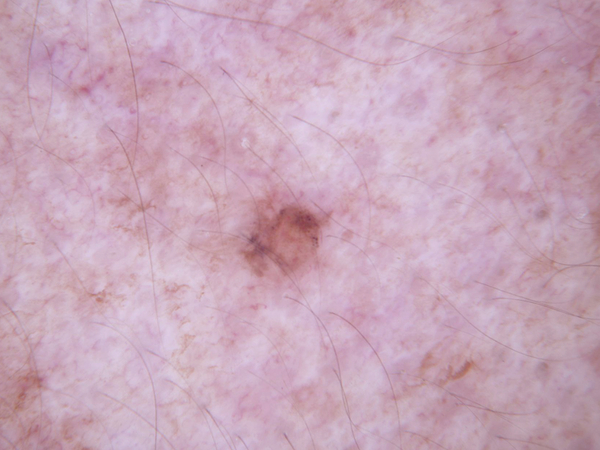

1/1 [==============================] - 0s 31ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


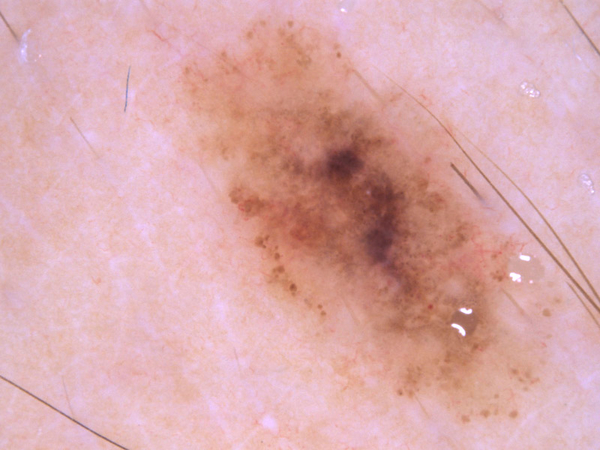

1/1 [==============================] - 0s 45ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


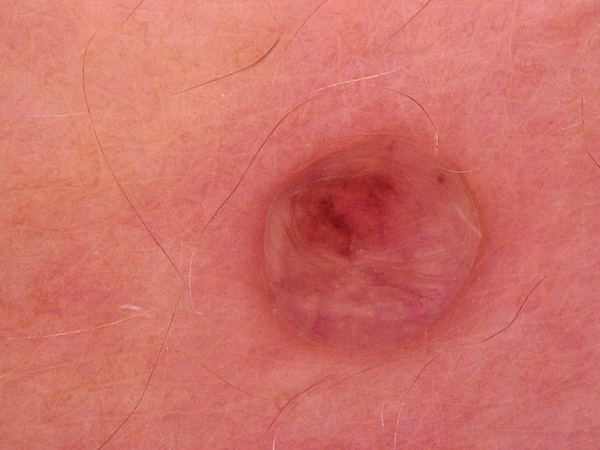

1/1 [==============================] - 0s 39ms/step
[[0. 0. 0. 0. 1. 0. 0. 0.]]
('nv', ' melanocytic nevi')


In [ ]:
!pip -v install google.colab
from google.colab.patches import cv2_imshow
srcdir = 'HAM10000_images_part_1'
count=0
for temp in os.listdir(srcdir):
    img = cv2.imread(os.path.join(srcdir, temp))
    cv2.imwrite(temp, img)
    cv2_imshow(img)
    img = cv2.resize(img, (28, 28))
    result = model.predict(img.reshape(1, 28, 28, 3))
    print(result)
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    count+=1
    if count>10:
        break